In [46]:
# Import necessary libraries
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


from torch import nn
from data import TimeFusionDataset
from timefusion import TimeFusion
from utils.metrics import variogram_score, crps_sum
from utils.modules import EarlyStopper

In [47]:
# Import dataset
train_data = pd.read_csv("../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:30]
test_data = test_data.iloc[:,:30]

full_data = pd.concat([train_data,test_data])
means = full_data.rolling(48,min_periods=48).mean()
norm_full_data = (full_data / means).to_numpy()
# TODO: Need to shift means so that they divide the one earlier

In [48]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [49]:
context_length = 48
prediction_length = 7*24

# Create each dataset
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)



In [7]:
from utils.modules import MeanScaler
from torch import optim
import time

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.scaler = MeanScaler(
            device = device,
            min_scale = 0.01
        )

        
        self.rnn = nn.LSTM(
            input_size = train_dataset.tensor_data.shape[1],
            hidden_size = 60,
            num_layers = 2,
            dropout = 0,
            batch_first = True,
            device=device
        )
        
        self.linear1 = nn.Linear(
            in_features = 60,
            out_features = 60,
            device =device
        )

        self.linear2 = nn.Linear(
            in_features = 60,
            out_features = 30,
            device=device
        )

        self.relu = nn.ReLU()


    def forward(self, x):
        x = x.permute((0,2,1))
        h, _  = self.rnn(x)

        x = self.linear1(h[:,-1])
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
    def train_network(self,train_loader,val_loader):
        self.train(True)

        optimizer = optim.Adam(params = self.parameters(), lr = 1e-4)

        epochs = 10
        loss_fn = nn.MSELoss()
        val_metrics = {"val_loss": loss_fn}

        for epoch in range(1, epochs + 1):
            running_loss = 0
            for i, data in enumerate(train_loader, start = 1):
                context, target = data
                context = context.to(device)
                target = target.to(device)

                context = self.scaler(context)
                target = torch.squeeze(self.scaler(target.unsqueeze(-1), update_scales = False))


                # Zero gradients
                optimizer.zero_grad()

                # Forward, loss calculation, backward, optimizer step
                predictions = self.forward(context)
                loss = loss_fn(predictions,target)
                loss.backward()
                optimizer.step()

                # Print training statistics
                running_loss += loss.item()
                average_loss = running_loss / i
                stat_string = "|" + "="*(30*i // len(train_loader)) + " "*(30 - (30*i // len(train_loader))) + f"|  Batch: {i} / {len(train_loader)}, Epoch: {epoch} / {epochs}, Average Loss: {average_loss:.4f}"
                print(stat_string)

            if val_loader is not None:
                with torch.no_grad():
                    running_loss = {key:0 for key in val_metrics.keys()}
                    for data in val_loader:
                        context, target = data
                        context = context.to(device)
                        target = target.to(device)

                        
                        context = self.scaler(context)
                        target = torch.squeeze(self.scaler(target.unsqueeze(-1), update_scales = False))


                        # Calculate prediction metrics
                        predictions = self.forward(context)
                        for key, metric_func in val_metrics.items():
                            running_loss[key] += metric_func(predictions,target).item() 
                    
                    for metric, value in running_loss.items():
                        print(value / len(val_loader))
                        stat_string += f", {metric}: {value / len(val_loader):.4f}"

                    #print(running_loss)

    
predictor = NeuralNetwork()

In [8]:
predictor.train_network(train_loader,val_loader)

|                              |  Batch: 1 / 170, Epoch: 1 / 10, Average Loss: 1.1001
|                              |  Batch: 2 / 170, Epoch: 1 / 10, Average Loss: 1.1368
|                              |  Batch: 3 / 170, Epoch: 1 / 10, Average Loss: 1.1606
|                              |  Batch: 4 / 170, Epoch: 1 / 10, Average Loss: 1.1696
|                              |  Batch: 5 / 170, Epoch: 1 / 10, Average Loss: 1.1716
|=                             |  Batch: 6 / 170, Epoch: 1 / 10, Average Loss: 1.1773
|=                             |  Batch: 7 / 170, Epoch: 1 / 10, Average Loss: 1.1662
|=                             |  Batch: 8 / 170, Epoch: 1 / 10, Average Loss: 1.1657
|=                             |  Batch: 9 / 170, Epoch: 1 / 10, Average Loss: 1.1689
|=                             |  Batch: 10 / 170, Epoch: 1 / 10, Average Loss: 1.1692
|=                             |  Batch: 11 / 170, Epoch: 1 / 10, Average Loss: 1.1740
|==                            |  Batch: 12 / 170, E

In [54]:
# Set the network into evaluation mode
predictor.train(False)
import copy

with torch.no_grad():
    idx = 50
    # Sample for the same length as prediction length
    samples = torch.zeros(size=(30,prediction_length))
    for pred_idx in range(prediction_length):

        # Get context Tensor at index
        context = test_dataset.get_sample_tensor(idx + pred_idx)

        context = copy.deepcopy(context)

        # Repeat token to give correct batch size
        context = context.unsqueeze(0)

        # Replace existing data into Tensor
        if pred_idx > 0:
            context[0,test_dataset.ts_columns,-pred_idx:] = samples[:,max(0,pred_idx - context.shape[2]):pred_idx]

        # Scale data
        context = predictor.scaler(context)

        x = predictor(context)

        x = predictor.scaler.unscale(x.unsqueeze(-1))

        samples[:,pred_idx] = x[0,:,0]

    samples = samples.cpu().numpy()


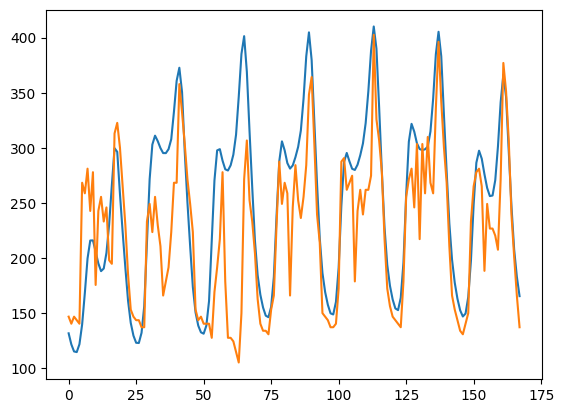

In [55]:
with torch.no_grad():
    tmp, tmp2 = test_dataset[idx]
    plt.plot(samples[15])
    plt.plot(test_dataset.tensor_data[idx:idx+prediction_length,15])

In [45]:
test_dataset.tensor_data[800,1]

tensor(27.0270, grad_fn=<SelectBackward0>)

In [31]:
tmp2.shape

torch.Size([30])

In [ ]:
predictor = TimeFusion(
    prediction_length = prediction_length,
    input_size = train_dataset.tensor_data.shape[1],
    output_size = len(train_dataset.ts_columns),
    hidden_size = 60,
    recurrent_layers = 2,
    dropout = 0.0,
    residual_layers = 2,
    scaling = True,
    device = device,
    scaler_kwargs = {"scaled_rows":list(range(30))}
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 89094


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/diffusion.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [ ]:
# optimizer = torch.optim.Adam(params=predictor.parameters(),lr=5e-4)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=40)

# predictor.train_network(
#     train_loader = train_loader,
#     epochs=40,
#     val_loader = val_loader,
#     val_metrics= {
#         "Val MAE": nn.L1Loss(),
#     },
#     optimizer = optimizer,
#     lr_scheduler= lr_scheduler,
#     early_stopper=EarlyStopper(patience=10),
#     save_weights = True,
#     weight_folder = "weights"
# )

In [ ]:
# Loading weights
predictor.load_state_dict(torch.load("weights/2023-05-16-18-09-05"))
predictor.eval()

TimeFusion(
  (scaler): MeanScaler()
  (diff_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=32, out_features=32, bias=True)
    (tanh1): Tanh()
    (projection2): Linear(in_features=32, out_features=32, bias=True)
  )
  (rnn): LSTM(38, 60, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=122, out_features=122, bias=True)
  (linear2): Linear(in_features=122, out_features=122, bias=True)
  (linear3): Linear(in_features=122, out_features=30, bias=True)
  (relu): ReLU()
)

In [ ]:
x = []
y = []

i = 24*30+prediction_length + 300
while i < norm_full_data.shape[0]:

    x.append(norm_full_data[i-24*30-prediction_length:i-prediction_length])
    y.append(norm_full_data[i-prediction_length:i])

    i += 5

x2 = np.array(x)
y2 = np.array(y)

In [ ]:
from sklearn.linear_model import LinearRegression

regs = []
for i in range(30):
    regs.append(LinearRegression().fit(x2[:,:,i], y2[:,:,i]))


Plots for idx: 0


/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_27738/3653320086.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  a = [torch.tensor([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0]]) for i,reg in enumerate(regs)]


Plots for idx: 50
Plots for idx: 100


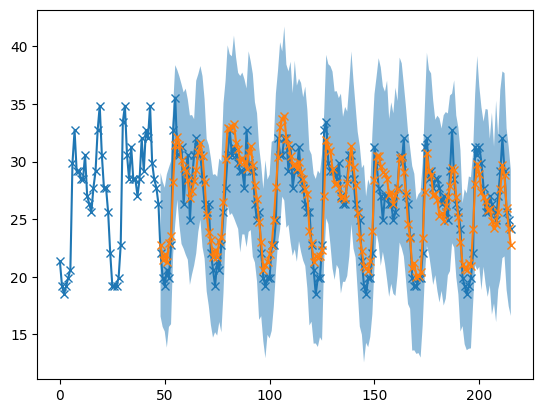

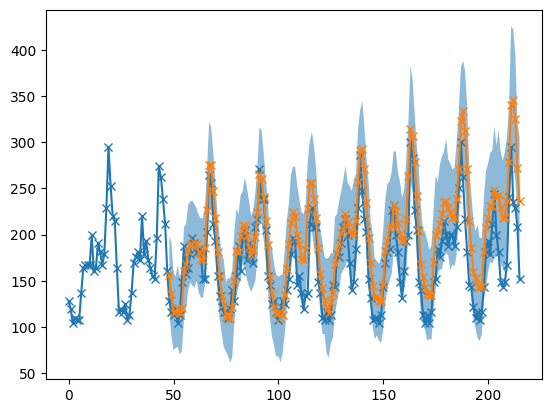

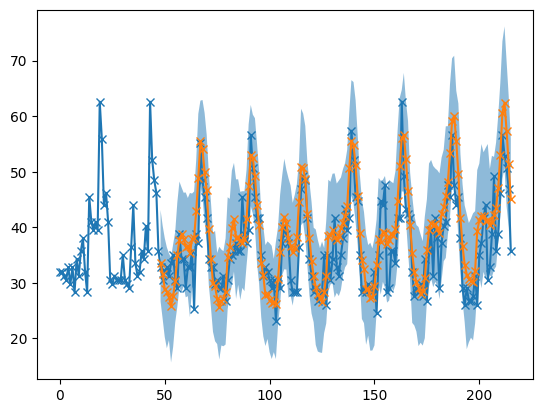

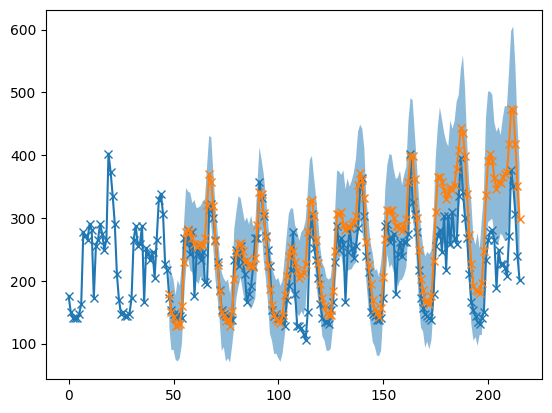

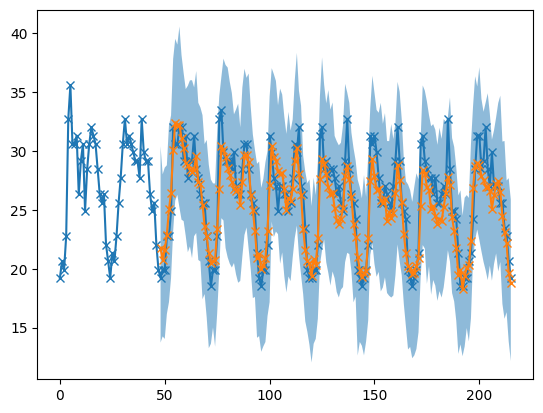

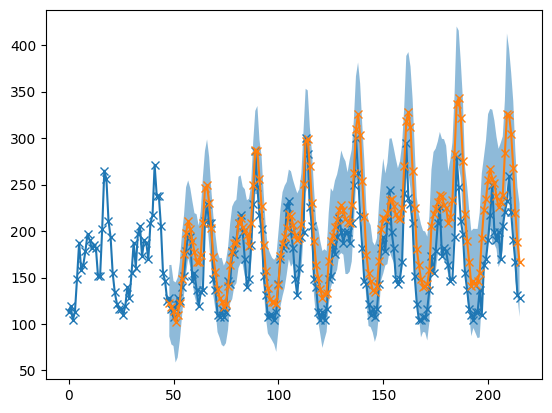

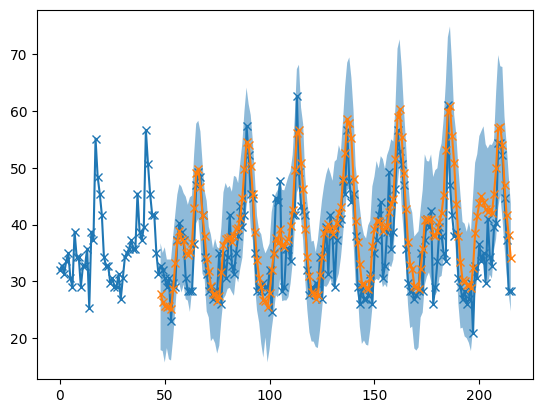

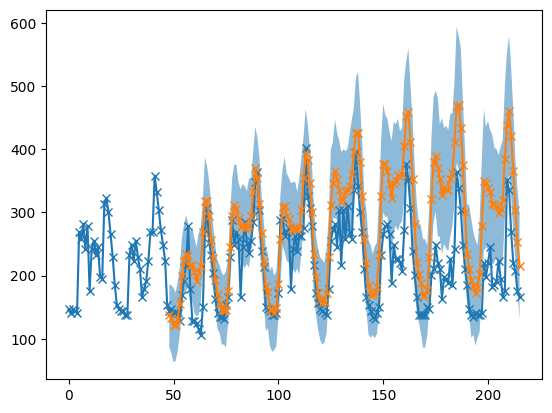

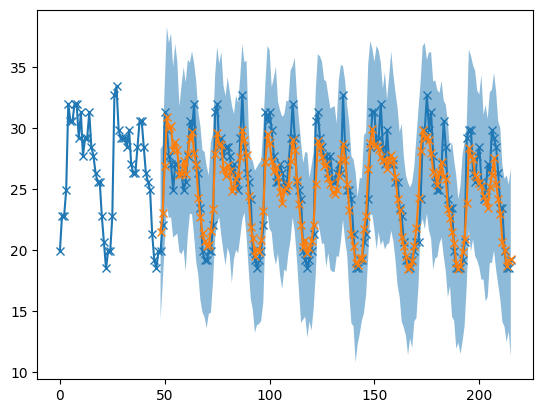

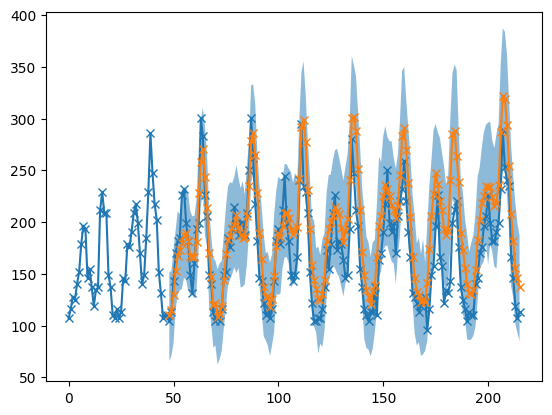

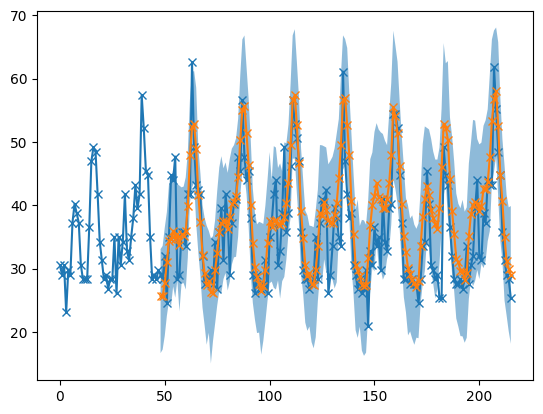

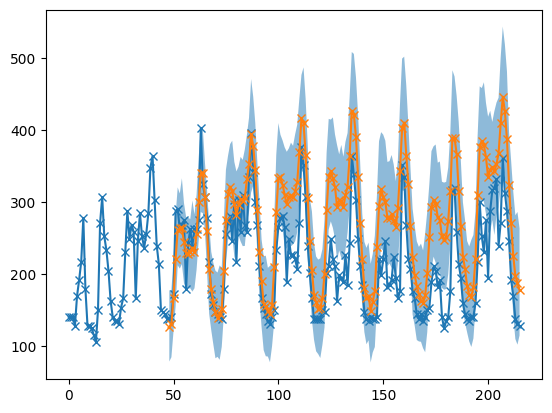

In [ ]:
full_data_array = full_data.to_numpy()

idx = 0
for idx in {0,50,100}:
    print(f"Plots for idx: {idx}")

    historical_data = []
    for i in range(prediction_length):
        a = [torch.tensor([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0]]) for i,reg in enumerate(regs)]
        break
        #a = norm_full_data[(idx + train_data.shape[0]+i)%(1*24):idx + train_data.shape[0]:1*24]
        #a = a[~np.isnan(a).any(axis=1)]
        #a = full_data_array[(idx + train_data.shape[0]+i)%(7*24):idx + train_data.shape[0]:7*24]
        historical_data.append(a)
    
    historical_data = torch.tensor(np.array([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0] for i,reg in enumerate(regs)])).T

    samples = predictor.sample(
        data = test_dataset,
        idx = idx,
        num_samples = 128,
        batch_size = 128,
        historical_data=historical_data
    )

    confidence = 0.1
    samples_cpu = samples.cpu()
    for i in range(samples_cpu.shape[1]):
        samples_cpu[:,i,:], _ = torch.sort(samples_cpu[:,i,:], dim=0)

    for ts in [1,5,10,15]:
        plt.figure()
        plt.plot(list(range(context_length + prediction_length)),test_dataset.tensor_data[idx:idx+context_length+prediction_length,ts],"-x")
        plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples_cpu[:,ts],dim = 0),"-x")
        plt.fill_between(list(range(context_length,context_length+prediction_length)), samples_cpu[int(confidence*samples_cpu.shape[0]),ts], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),ts],alpha=0.5)
        plt.savefig(f"images/original_{idx}_{ts}.png")

In [ ]:
historical_data.shape

torch.Size([168, 30])

In [ ]:
# Sample for first two weeks of test data
samples = []
for i in range(14):
    idx = 24*i

    # historical_data = []
    # for i in range(prediction_length):
    #     a = norm_full_data[(idx + train_data.shape[0]+i)%(1*24):idx + train_data.shape[0]:1*24]
    #     a = a[~np.isnan(a).any(axis=1)]
    #     historical_data.append(a)

    historical_data = torch.tensor([reg.predict([norm_full_data[idx + train_data.shape[0] - 24*30:idx + train_data.shape[0],i]])[0] for i,reg in enumerate(regs)]).T

    samples.append(
        predictor.sample(
            data = test_dataset,
            idx = idx,
            num_samples = 128,
            batch_size = 128,
            historical_data=historical_data
        ).cpu()
    )

samples = torch.cat([x.unsqueeze(0) for x in samples], dim = 0)

realisations = []
for i in range(14):
    idx = 24*i

    realisations.append(
        test_dataset.tensor_data[context_length + idx:idx + context_length + prediction_length,test_dataset.ts_columns].T
    )

realisations = torch.cat([x.unsqueeze(0) for x in realisations], dim = 0)

In [57]:
# Set the network into evaluation mode
predictor.train(False)
import copy

with torch.no_grad():
    a = []
    for idx in range(0,14*24,24):
        # Sample for the same length as prediction length
        samples = torch.zeros(size=(30,prediction_length))
        for pred_idx in range(prediction_length):

            # Get context Tensor at index
            context = test_dataset.get_sample_tensor(idx + pred_idx)

            context = copy.deepcopy(context)

            # Repeat token to give correct batch size
            context = context.unsqueeze(0)

            # Replace existing data into Tensor
            if pred_idx > 0:
                context[0,test_dataset.ts_columns,-pred_idx:] = samples[:,max(0,pred_idx - context.shape[2]):pred_idx]

            # Scale data
            context = predictor.scaler(context)

            x = predictor(context)

            x = predictor.scaler.unscale(x.unsqueeze(-1))

            samples[:,pred_idx] = x[0,:,0]

        samples = samples.cpu().numpy()

        a.append(samples)


In [59]:
a = torch.tensor(a)

/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_28205/3005387063.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  a = torch.tensor(a)


In [60]:
a.shape

torch.Size([14, 30, 168])

In [65]:
realisations.shape
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error


print(mean_squared_error(realisations.flatten(), a.flatten()))

print(mean_absolute_error(realisations.flatten(), a.flatten()))

print(median_absolute_error(realisations.flatten(), a.flatten()))

310.64813
10.329821
4.8040667


In [ ]:
# Get numerical values for performance of network
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# MAE and MdAE of average prediction
mse = mean_squared_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
mae = mean_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
mdae = median_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
print(f"MSE: {mse}, MAE: {mae}, MDAE: {mdae}")


# Variogram and CRPS_SUM
var_score = np.mean([variogram_score(realisations[i].numpy(), samples[i].numpy(),**{"weights":"local","window_size":3}) for i in range(realisations.shape[0])])
crps_score = np.mean([crps_sum(realisations[i].numpy(), samples[i].numpy()) for i in range(realisations.shape[0])])

print("VAR:",var_score,"CRPS_sum:",crps_score)

MSE: 1544.9207763671875, MAE: 19.290332794189453, MDAE: 6.057640075683594
VAR: 919838.0362688357 CRPS_sum: 164.3801067808908


In [ ]:
means = train_data.rolling(48,min_periods=48).mean()
norm_train_data = (train_data / means).dropna()

In [ ]:
vals = []
for i in range(2,73): 
    k = norm_train_data.rolling(i,min_periods=i).apply(lambda x: abs(x[0] - x[-1])).dropna().sum()
    vals.append(k)
    print(i,k)

2 0     10818.993780
1      2079.342634
2      2555.013056
3      3441.336765
4      3259.050846
5      3176.058898
6      4915.862017
7      2643.766719
8      4753.513345
9      4465.275461
10     3173.106758
12     4427.596243
13     2594.407506
15     3457.043769
16     2801.471421
17     3468.552243
18     3975.982082
19     3197.640392
20     2845.750898
21     5446.588029
22     5328.146314
24     3898.511513
25     4182.254297
26     3755.305961
27     2748.353221
28     1948.475084
30     3189.215027
33     3408.000275
34     3591.037529
35     5468.203685
dtype: float64
3 0     12349.496613
1      3290.667682
2      3359.857889
3      5239.454802
4      4508.137666
5      4844.857615
6      6408.225730
7      3813.435899
8      6870.331538
9      6394.779321
10     4568.764505
12     6401.244842
13     4005.696618
15     5465.866916
16     4218.682666
17     5285.306247
18     5409.069032
19     4430.455940
20     4408.168267
21     7580.841613
22     8183.135385
24     5884.

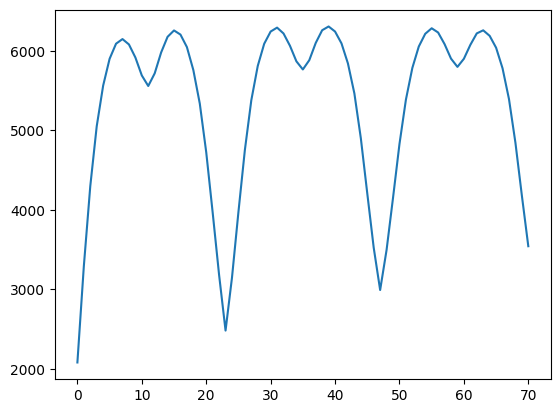

In [ ]:
plt.plot([i[1] for i in vals])

In [ ]:
import math
math.exp(-0.03*300)

train_array = train_data.to_numpy()

idx = 20000
x = []
for i in range(24):
    tmp = train_array[(idx+i)%24:idx:24]
    tmp2 = np.exp(-0.03*np.array(range(tmp.shape[0],0,-1)))
    tmp2 /= sum(tmp2)
    x.append(np.sum(tmp*np.expand_dims(tmp2,-1),0))
    
x = np.array(x)

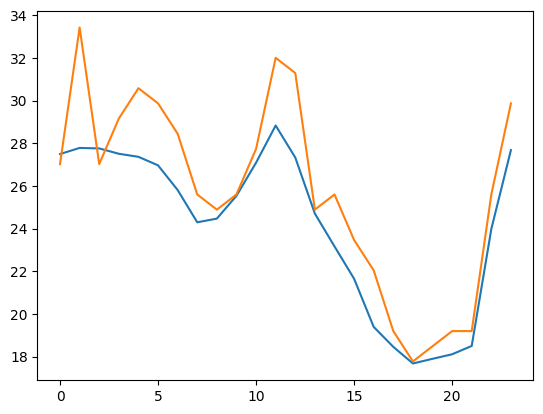

In [ ]:
plt.plot(x[:,1])
plt.plot(train_array[idx:idx+24,1])

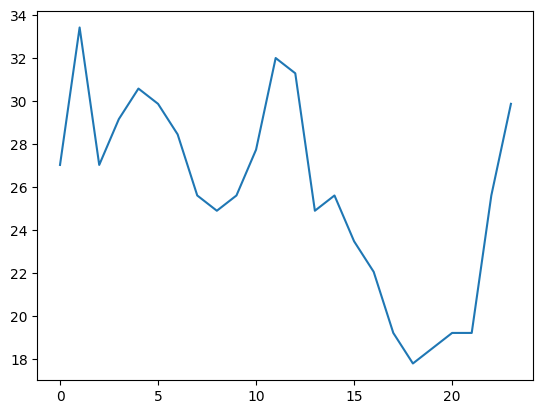

In [ ]:
plt.plot(train_array[idx:idx+24,1])

In [ ]:
x.sum(1).shape

(24, 30)

In [ ]:
np.array(x).shape

(24, 833, 30)

In [ ]:
train_array = train_data.to_numpy()

train_array[:100:24,0]

array([ 3.8071066 ,  3.8071066 ,  3.8071066 ,  5.07614213, 17.76649746])

In [ ]:
idx % 24

4

In [ ]:
train_data.shape

(24096, 30)